# Check emission pairs to see which are missing in construction

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_stat_scm
from src.utils.sem_utils.emissions import get_emissions_input_output_pairs
from src.utils.sequential_causal_functions import sequentially_sample_model
from src.utils.sem_utils.emissions import fit_sem_emit_fncs
from numpy.random import seed


seed(seed=0)

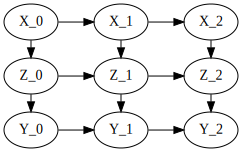

In [52]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag, exploration_sets, intervention_domain, true_objective_values  = setup_stat_scm(T=3)
# This is just a snapshot of the DAG at hand
dag_view

In [183]:
dag.add_edge("Z_0","X_0")
dag.add_edge("Z_1","X_1")
dag.add_edge("Z_2","X_2")

dag.remove_edge("X_0","Z_0")
dag.remove_edge("X_1","Z_1")
dag.remove_edge("X_2","Z_2")

In [49]:
node_children, node_parents, emission_pairs = get_emissions_input_output_pairs(T, dag)
emission_pairs

{('Z_0',): 'Y_0',
 ('X_0',): 'Z_0',
 ('Z_1',): 'Y_1',
 ('X_1',): 'Z_1',
 ('W_1',): 'X_1',
 ('Z_2',): 'Y_2',
 ('X_2',): 'Z_2'}

# Convert to adjacency matrix and get all relationships from that

In [112]:
from networkx.linalg.graphmatrix import adjacency_matrix
from networkx.convert import to_dict_of_lists
import numpy as np
from scipy.linalg import block_diag 
from src.utils.dag_utils.adjacency_matrix_utils import get_emit_and_trans_adjacency_mats

In [ ]:
def func(G):
    # Standard
    A = adjacency_matrix(G)
    # In array form 
    AA = np.asarray(A.todense())
    # List of all nodes in G
    nodes = np.array(dag.nodes())
    # List of all leaf/source nodes/vertices in G (confounders are not included)
    sources = nodes[~AA.sum(axis=0).astype(bool)].tolist()

    # Get all input-output tuples

In [3]:
dag.add_node("W_1")
dag.add_edge("W_1","X_1")

In [53]:
A = adjacency_matrix(dag)
AA = np.asarray(A.todense())

In [87]:
gg = dag.subgraph(['X_0', 'Z_0', 'Y_0', 'X_1', 'Z_1', 'Y_1'])
a = adjacency_matrix(gg)
aa = np.asarray(a.todense())
aa

array([[0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0]])

In [111]:
gg.nodes()

NodeView(('X_0', 'Z_0', 'Y_0', 'X_1', 'Z_1', 'Y_1'))

In [114]:
adjacency_matrix(gg)

<6x6 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [116]:
get_emit_and_trans_adjacency_mats(dag)

3 3


(array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [48]:
to_dict_of_lists(dag)

{'X_0': ['Z_0', 'X_1'],
 'Z_0': ['Y_0', 'Z_1'],
 'Y_0': ['Y_1'],
 'X_1': ['Z_1', 'X_2'],
 'Z_1': ['Y_1', 'Z_2'],
 'Y_1': ['Y_2'],
 'X_2': ['Z_2'],
 'Z_2': ['Y_2'],
 'Y_2': [],
 'W_1': ['X_1']}